In [2]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from utils import *
from utils.GridWorldPitfalls import GridWorldWithPitfalls
from utils.AgentBasics import Agent, Policy
from tqdm import tqdm
import cv2

# Expected Sarsa
$$ Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma \sum_{a} \pi(a|S_{t+1}) Q(S_{t+1}, a) - Q(S_t, A_t) \right] $$

$$ \pi(a|S_t) \leftarrow \frac{\exp(\beta Q(S_t, a))}{\sum_{b} \exp(\beta Q(S_t, b))} $$

清晰可见这个Expected Sarsa和Sarsa，Q-learning的区别就是：<p>
Sarsa使用由policy选出来的下一个action进行更新，Q-learning用最优的下一个action来更新，而Expected Sarsa是用Q值的期望来更新，它同时考虑了所有的下一个可能得action<p>

In [9]:
def expectedSarsa(grid_world: GridWorldWithPitfalls):
    agent = Agent(grid_world, Policy(grid_world))
    # Make state value of terminal state
    agent.initTerminalValues(grid_world)
    gamma = 0.8
    step_size = 0.1

    for it in tqdm(range(6000), desc="ExpectedSarsa"):
        # initialize eposide with non terminal state
        grid_world.reset()
        while grid_world.isTerminalState(grid_world.start_sid):
            grid_world.reset()  # reset with a random start state

        agent.policy = agent.action_value.copy(grid_world)
        agent.policy.normalize()

        old_sid = grid_world.current_sid

        while True:
            # random_action_id = np.random.randint(0, grid_world.n_actions)
            action_id = agent.takeAction(old_sid, epsilon=0.4)
            r = grid_world.step(action_id)
            new_sid = grid_world.current_sid

            # update state value
            agent.state_value[old_sid] += step_size * (r + gamma * agent.state_value[new_sid] - agent.state_value[old_sid])

            if grid_world.isTerminalState(grid_world.current_sid):
                ### --- Action value for terminal state --- ###
                agent.action_value[old_sid, action_id] += step_size * (r - agent.action_value[old_sid, action_id])
                break

            # take new action
            # new_aid = agent.takeAction(new_sid, epsilon=0.4)

            # update action value
            agent.action_value[old_sid, action_id] += step_size * (r + gamma * np.sum(agent.policy[new_sid] * agent.action_value[new_sid]) - agent.action_value[old_sid, action_id])

            old_sid = new_sid

    for sid in grid_world.getNonTerminalStateIds():
        best_action_id = agent.action_value[sid].argmax()
        agent.policy[sid] = 0
        agent.policy[sid, best_action_id] = 1

    # Run another time to get path
    grid_world.reset(grid_world.coordToStateId(8, 8))
    while not grid_world.isTerminalState(grid_world.current_sid):
        action_id = agent.takeAction(grid_world.current_sid, epsilon=0)
        grid_world.step(action_id)

    grid_world.render(agent, figsize=(10, 10))
    plt.show()

ExpectedSarsa: 100%|██████████| 6000/6000 [00:21<00:00, 276.30it/s]


111 [(8, 8), (8, 9), (7, 9), (6, 9), (5, 9), (5, 10), (4, 10)]


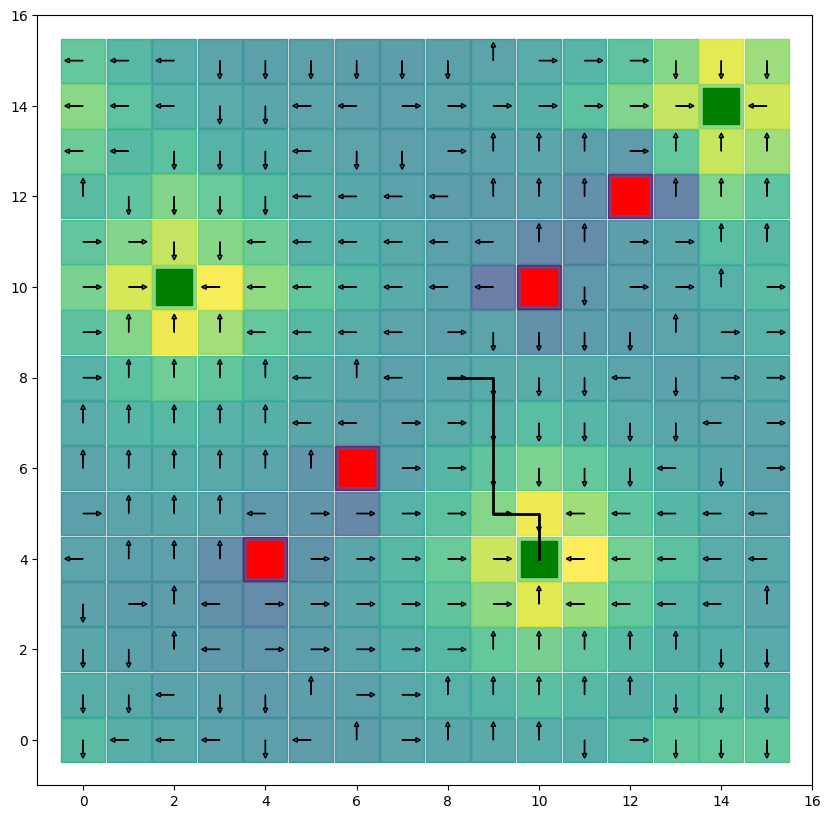

In [10]:
expectedSarsa(GridWorldWithPitfalls(world_size=16, 
                        win_states=[(10, 2), (4, 10), (14, 14)], 
                        fail_states=[(4, 4), (6, 6), (10, 10), (12, 12)]
                        )
    )